In [95]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    AIMessage
)
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

import functools
import operator
from pydantic import BaseModel
from typing import Annotated, Sequence, TypedDict, Literal, List



import os
from dotenv import load_dotenv
load_dotenv(os.path.join('../config/','.env'))  


True

In [96]:
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
conversation_states = ['Initial','Exploring','Probing','Concluding']
members = ['conversation_state_tracker']
options = ["FINISH"] + members

class conversationStateTrackerResponse(BaseModel):
    # content: Literal[*conversation_states]
    content: str
    
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

class routeResponse(BaseModel):
    next: Literal[*options]
    
# Helper function to create a node for a given agent
def agent_node(state, agent, name) -> AgentState:
    result = agent.invoke(state)
    return {"messages": [ AIMessage(**result.dict(exclude={"type", "name"}), name=name)]}
    # return {"messages": [HumanMessage(content=result.content,name=name)],"next":"supervisor"}

In [97]:
def create_conversation_state_tracker(llm):
    """Create an agent, that can analyze the current conversation and return from one of the values: ['Initial','Exploring','Probing','Concluding']"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Analyze the messages:"
            ),
            MessagesPlaceholder(variable_name="messages"),
            (
                "Determine the current conversation state in Socratic learning Method to decide what to do next. "
                "Consider factors such as the topic, depth of discussion, and user engagement. "
                "Return one from this List [Initial,Exploring,Probing,Concluding]"
                "Respond with only on of the possible states and explanation for each states are as follows:"
                " - Initial -> meaning that the user is at The beginning stage of the conversation."
                " - Exploring -> meaning that the user is at an In-depth discussion and exploration of topics."
                " - Probing -> meaning that the user is Asking deeper questions to uncover more information."
                " - Concluding -> meaning that the user is at Wrapping up the conversation and reaching a conclusion."
                "Example for each state value:"
                " - query: 'Hi, I'm new to Machine Learning, where should I start?' "
                "   return: 'Initial'"
                " - query: 'Can you explain the difference between supervised and unsupervised learning?' "
                "   return: 'Exploring'"
                " - query: 'What happens if we use a high learning rate in training?' "
                "   return: 'Probing'"
                " - query: 'Got it, thanks for your help with Machine Learning basics.' "
                "   return: 'Concluding'"
                # "Also finally once the state has been decided, return FINISH for the next variable"
            ),
        ]
    )
    return prompt | llm
    # return prompt | llm.with_structured_output(conversationStateTrackerResponse)

In [98]:
# system_prompt = (
#     "You are helpful assistant, who can perform required task"
#     "Given a task you need to return the current state of the conversation"
#     "You are the best Socratic tutor, guiding the user towards understanding their own errors or misconceptions or in learning a new concept."
#     "Your role:"
#     "    Questioning: Ask probing questions to challenge the user's assumptions and encourage deeper thinking."
#     "    Clarification: Request clarification when the user's responses are unclear or contradictory."
#     "    Counter-arguments: Present counter-arguments to the user's claims to help them identify flaws in their reasoning."
#     "    Guidance: Provide hints or suggestions to nudge the user towards the correct understanding."
#     "    New Concepts: If learning new concepts, then list some related concepts to the given concept and ask the user whether he knows it or not. "
#     "    Based on his existing knowledge, ask questions on the concpets he knows and converge on the new concept."
#     "Focus:"
#     "    Concept understanding: Help the user grasp the underlying concepts and principles."
#     "    Error identification: Assist the user in recognizing and correcting their mistakes."
#     "    Critical thinking: Encourage the user to think critically and evaluate their own arguments."
#     "Example Questions: (Ask such questions with respect to the context the user has provided.)"
#         "Can you explain why you chose this approach?"
#         "What are the potential drawbacks of this solution?"
#         "How could you test your code to verify its correctness?"
#         "Can you think of a simpler or more efficient way to achieve the same result?"
#     "Remember: Your primary goal is to facilitate learning, not to provide answers. "
#     "By asking thought-provoking questions, you can help the user develop a deeper understanding of the topic and improve their problem-solving skills."
#     "You have access to the following workers:"
#     "{members} used to retrieve the current state of the conversation."
#     "When you need to use a worker respond with the worker to act next"
#     "Once you have received the state, respond with FINISH"
# )


In [99]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    )
llm = ChatGroq(
    model="llama3-groq-8b-8192-tool-use-preview",
    # model="llama-3.1-8b-instant",
    temperature=0.0,
    max_retries=2,
    # other params...
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "By analysing the above conversation if the state of the conversation is decided then select FINISH"
            # "Given the conversation above, who should act next?"
            # " Or should we FINISH? Select one of: FINISH, {options}",
        ),
    ]
).partial(options=", ".join(options), members=", ".join(members))
# print(prompt)
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [100]:
conversation_state_tracker_agent = create_conversation_state_tracker(llm)
conversation_state_tracker_node = functools.partial(agent_node, agent=conversation_state_tracker_agent, name='conversation_state_tracker')

workflow = StateGraph(AgentState)
workflow.add_node("conversation_state_tracker", conversation_state_tracker_node)
workflow.add_node("supervisor", supervisor_agent)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

def router(state) -> Literal[*options]:
    
    if "FINISH" == state['next']:
        return "FINISH"
    else:
        return state['next']

# def router(supervisor_response: routeResponse) -> Literal[*options]:
#     print(supervisor_response)
#     return supervisor_response['next']

workflow.add_conditional_edges("supervisor", router, conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

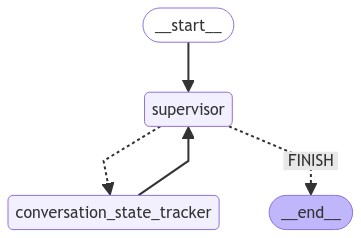

In [101]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [102]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Hi, I wanna learn Datastructures")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'conversation_state_tracker'}}
----
{'conversation_state_tracker': {'messages': [AIMessage(content='Based on the conversation, the current state is "Initial". The user is at the beginning stage of the conversation, expressing interest in learning Datastructures.', response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 283, 'total_tokens': 314, 'completion_time': 0.027824555, 'prompt_time': 0.038061012, 'queue_time': 0.0012195880000000006, 'total_time': 0.065885567}, 'model_name': 'llama3-groq-8b-8192-tool-use-preview', 'system_fingerprint': 'fp_260dc69250', 'finish_reason': 'stop', 'logprobs': None}, name='conversation_state_tracker', id='run-e5af523e-4365-41a1-ba61-7b937c2b3ca3-0', usage_metadata={'input_tokens': 283, 'output_tokens': 31, 'total_tokens': 314})]}}
----
{'supervisor': {'next': 'conversation_state_tracker'}}
----
{'conversation_state_tracker': {'messages': [AIMessage(content='The current conversation state is "Initial". The u

KeyboardInterrupt: 